<a href="https://colab.research.google.com/github/Kussil/CVX_Rice_project/blob/main/04_Stock_Modeling/Stock_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.2 MB/s eta 0:00:00


In [2]:
from google.colab import output
import textwrap
output.enable_custom_widget_manager()

In [118]:
# Import github token with google secrets thingy and clone git repository
import os
from google.colab import userdata
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/CVX_Rice_project.git

Cloning into 'CVX_Rice_project'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 329 (delta 70), reused 77 (delta 39), pack-reused 200
Receiving objects: 100% (329/329), 110.20 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Updating files: 100% (24/24), done.


In [5]:
import pandas as pd
df_chunk = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_chunkdata.csv')
df = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_data.csv')

In [17]:
df.drop(df[df['Ticker'] == 'BP.'].index, inplace=True)
ticker_list = df['Ticker'].unique().tolist()
ticker_list

['CVX', 'PSX', 'HES', 'XOM', 'SHEL', 'OXY', 'VLO', 'TTE', 'MPC', 'EQNR']

In [45]:
min_date = df['Date'].min()
min_date

'2019-02-01'

In [65]:
import yfinance as yf
ticker = ticker_list#ticker_list
price = yf.download(ticker, start='2024-01-01')["Adj Close"]
ret = price.pct_change().dropna()
ret.name = "ret"
ret.describe()

[*********************100%%**********************]  10 of 10 completed


Ticker,CVX,EQNR,HES,MPC,OXY,PSX,SHEL,TTE,VLO,XOM
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.000808,-0.000323,0.000561,0.001818,0.000418,0.000874,0.000967,0.000752,0.002397,0.001259
std,0.011016,0.015640,0.013107,0.018785,0.011892,0.015284,0.009473,0.011381,0.016995,0.010894
min,-0.030421,-0.071942,-0.034574,-0.093711,-0.030632,-0.054969,-0.031975,-0.030746,-0.045609,-0.027776
25%,-0.004835,-0.006574,-0.006974,-0.007269,-0.006399,-0.008121,-0.003890,-0.005941,-0.008090,-0.005796
50%,0.001371,0.000201,0.002610,0.002349,0.000951,0.000883,0.001085,0.002422,0.002951,0.000167
75%,0.006907,0.010836,0.008679,0.011204,0.008389,0.011138,0.006297,0.006777,0.012415,0.008703
max,0.034007,0.027675,0.036853,0.060884,0.049040,0.037652,0.027091,0.028104,0.052412,0.028659


In [68]:
# add overall article sentiment
df_2 = df
df_2['Sentiment'] = df_2[['Neutral', 'Positive', 'Negative']].idxmax(axis=1)

# aggregate by ticker and date
df_grouped = df_2.groupby(['Ticker', 'Date']).agg(
    article_count=('Article Headline', 'size'),
    neutral_count=('Sentiment', lambda x: (x == 'Neutral').sum()),
    positive_count=('Sentiment', lambda x: (x == 'Positive').sum()),
    negative_count=('Sentiment', lambda x: (x == 'Negative').sum()),
    neutral_avg=('Neutral','mean'),
    positive_avg=('Positive','mean'),
    negative_avg=('Negative','mean'),
).reset_index()
df_grouped['Date String'] = df_grouped['Date'].astype(str)

# reshape ret same day
ret2 = ret.stack().reset_index()
ret2.columns = ['Date', 'Ticker', 'Returns']
ret2['Date'] = pd.to_datetime(ret2['Date'], format='mixed')
ret2['Date']= pd.to_datetime(ret2['Date']).dt.date
ret2['Date String']= ret2['Date'].astype(str)
ret2.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret2, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])
# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged

,Ticker,Date,article_count,neutral_count,positive_count,negative_count,neutral_avg,positive_avg,negative_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN)
0,CVX,2019-02-01,2,0,0,2,0.154725,0.083628,0.761647,NaN,0.019066,NaN,0.019066
1,CVX,2019-02-08,1,0,0,1,0.047401,0.084045,0.868554,NaN,0.019066,NaN,0.019066
2,CVX,2019-03-04,2,0,0,2,0.253340,0.113008,0.633652,NaN,0.019066,NaN,0.019066
3,CVX,2019-04-12,1,0,0,1,0.058440,0.017430,0.924130,NaN,0.019066,NaN,0.019066
4,CVX,2019-04-15,1,0,0,1,0.170081,0.028138,0.801782,NaN,0.019066,NaN,0.019066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,XOM,2024-05-07,1,0,1,0,0.031351,0.580889,0.387760,-0.004968,-0.004968,0.019716,0.019716
3344,XOM,2024-05-09,1,0,0,1,0.188977,0.233985,0.577038,0.019716,0.019716,-0.004053,-0.004053
3345,XOM,2024-05-10,2,0,1,1,0.100749,0.556811,0.342440,-0.004053,-0.004053,NaN,0.015017
3346,XOM,2024-05-11,1,0,0,1,0.082041,0.428641,0.489318,NaN,0.015017,0.015017,0.015017


In [119]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data.csv', index=False)
#Copy CSV to GitHub Repository
!cp /content/sample_data/sent_stock_data.csv /content/CVX_Rice_project/04_Stock_Modeling/
#Commit and Push Changes
!git config --global user.email "bw58@rice.edu"
%cd /content/CVX_Rice_project/04_Stock_Modeling/
!git add sent_stock_data.csv
!git commit -m "Add sent_stock_data.csv"
!git push origin main

/content/CVX_Rice_project/04_Stock_Modeling
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	CVX_Rice_project/

nothing added to commit but untracked files present (use "git add" to track)
To https://github.com/Kussil/CVX_Rice_project.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/Kussil/CVX_Rice_project.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


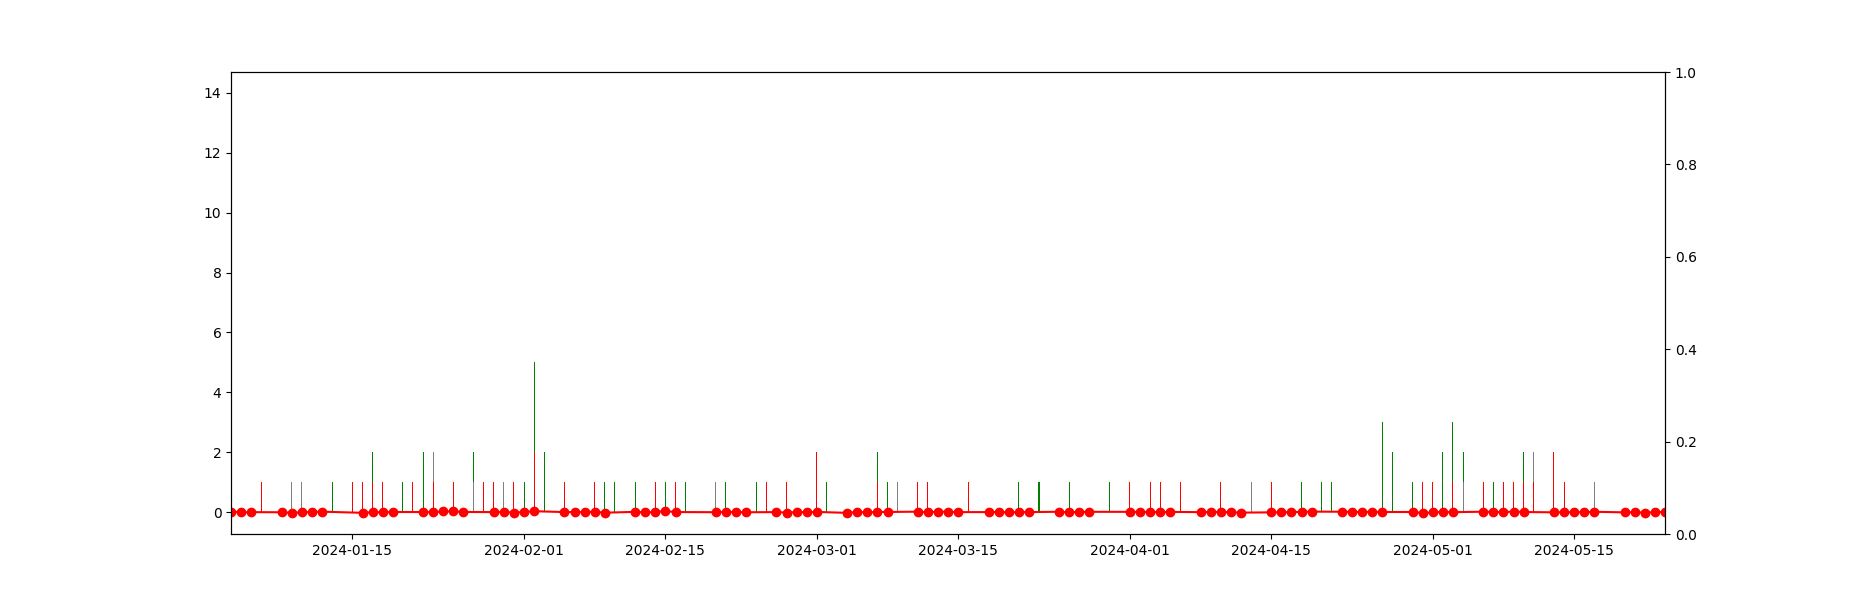

In [93]:
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2 # points

ax1.plot(ret.index, ret['CVX'], 'ro-', picker=tolerance)

#stacked bar
dates = df_merged['Date']
weights = {
    "Negative": df_merged['negative_count'].tolist(),
    "Neutral": df_merged['neutral_count'].tolist(),
    "Positive": df_merged['positive_count'].tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
  p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
  bottom += weight

ax1.set_xlim(left=ret.index.min(),right=ret.index.max())
ax2.set_xlim(left=ret.index.min(),right=ret.index.max())

def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

In [107]:
df_dropna = df_merged.dropna()

In [108]:
X = df_dropna.drop(columns=['Date','Ticker','Returns','Returns (no NaN)', 'Returns Next Day', 'Returns Next Day(no NaN)'])
X

,article_count,neutral_count,positive_count,negative_count,neutral_avg,positive_avg,negative_avg
416,1,0,0,1,0.037787,0.476323,0.485889
417,2,0,1,1,0.039173,0.403487,0.557341
428,1,0,0,1,0.142672,0.223620,0.633708
431,1,0,0,1,0.096722,0.070085,0.833192
1056,1,0,0,1,0.208069,0.115943,0.675988
1600,1,0,0,1,0.327290,0.116457,0.556254
2413,1,0,0,1,0.181958,0.267023,0.551020
3298,1,1,0,0,0.510540,0.043126,0.446334
3303,2,0,2,0,0.337077,0.364511,0.298412
3309,1,0,0,1,0.021194,0.060942,0.917864


In [113]:
y = df_dropna['Returns (no NaN)'].apply(lambda x: 1 if x > 0 else 0)
y

416     0
417     0
428     0
431     1
1056    1
1600    1
2413    1
3298    0
3303    0
3309    0
3312    0
3320    1
3332    0
3338    1
3339    0
3340    1
3343    0
3344    1
Name: Returns (no NaN), dtype: int64

In [115]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training set
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5
